## Libraries

In [1]:
!pip install python_speech_features

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for python-speech-features: filename=python_speech_features-0.6-py3-none-any.whl size=5888 sha256=15aa0c291ce77b176c5b98d88141158e379f9e8910571fe236588647fdcdf3f5
  Stored in directory: /root/.cache/pip/wheels/b0/0e/94/28cd6afa3cd5998a63eef99fe31777acd7d758f59cf24839eb
Successfully built python-speech-features


In [2]:
import os 
import sys
import json  
import time
from   datetime                import date

from collections import Counter
import pandas                  as pd
import numpy                   as np 
import matplotlib.pyplot       as plt  
import seaborn                 as sn
from sklearn.metrics import confusion_matrix, accuracy_score

import tensorflow              as tf
from   tensorflow              import keras
from   tensorflow.keras        import layers, Input, backend
from   tensorflow.keras.layers import Dense, Activation, ZeroPadding2D, BatchNormalization, Conv2D, Permute
from   tensorflow.keras.layers import Lambda, Bidirectional, LSTM, GRU
from   tensorflow.keras.models import Model

from   scipy.io                import wavfile
from   python_speech_features  import mfcc, logfbank
import wave 

import itertools
import cProfile
from IPython.display            import Audio

# Colab and Drive Libraries
from   google.colab            import drive

## Mounting Google's Drive (only for data purposes)

In [3]:
drive.mount('/content/drive') # to attempt to forcibly remount -> force_remount=True

# paths
FRA_PATH, FEDE_PATH = "/content/drive/MyDrive/University/HDA/HDA_Project/project", "/content/drive/MyDrive"

# Setting the working directory 
# os.chdir(FRA_PATH)
os.chdir(FEDE_PATH)

Mounted at /content/drive


## Utils

In [4]:
sys.path.append('./src/features')
sys.path.append('./src/data')
sys.path.append('./src/models')

In [5]:
import constants as cs
import feature_utils  as fs
import data_utils     as ds
import training_utils as ts

## Graphic Settings

In [ ]:
ds.set_dark_theme() if input("Are you in dark mode? y/n:   ").lower() == "y" else print("Hurts your eyes")

Are you in dark mode? y/n:   y


## Filepaths

In [6]:
# Path of the dataset
DATASET_PATH = "data/raw/dataset_v2/"

# Path of .npy files
BINARIES_PATH = "data/binaries/"

## Loading Binaries

In [7]:
X_train = np.load(BINARIES_PATH + "X_train_complete.npy")
X_valid = np.load(BINARIES_PATH + "X_valid_complete.npy")
X_test = np.load(BINARIES_PATH + "X_test_complete.npy")

y_train = np.load(BINARIES_PATH + "y_train_complete.npy")
y_valid = np.load(BINARIES_PATH + "y_valid_complete.npy")
y_test = np.load(BINARIES_PATH + "y_test_complete.npy")

filenames_train = np.load(BINARIES_PATH + "filenames_train_complete.npy")
filenames_valid = np.load(BINARIES_PATH + "filenames_valid_complete.npy")
filenames_test = np.load(BINARIES_PATH + "filenames_test_complete.npy")

### Extracting first 13 dimensions from them

In [8]:
X_train_envelope, X_valid_envelope, X_test_envelope = ds.envelope_coefficients(X_train), ds.envelope_coefficients(X_valid), ds.envelope_coefficients(X_test)

In [ ]:
# checking dimensions
print("X_train: ", X_train_envelope.shape,  "\ny_train: ", y_train.shape, "\nX_valid: ", X_valid_envelope.shape, "\ny_valid: ", y_valid.shape, "\nX_test: ", X_test_envelope.shape,  "\ny_test: ",  y_test.shape)

X_train:  (76364, 13, 99) 
y_train:  (76364,) 
X_valid:  (8947, 13, 99) 
y_valid:  (8947,) 
X_test:  (10083, 13, 99) 
y_test:  (10083,)


In [9]:
X_train_envelope, y_train = ts.reshape(X_train_envelope, y_train)
X_valid_envelope, y_valid = ts.reshape(X_valid_envelope, y_valid)
X_test_envelope, y_test = ts.reshape(X_test_envelope, y_test)

In [ ]:
# checking dimensions
print("X_train: ", X_train_envelope.shape,  "\ny_train: ", y_train.shape, "\nX_valid: ", X_valid_envelope.shape, "\ny_valid: ", y_valid.shape, "\nX_test: ", X_test_envelope.shape,  "\ny_test: ",  y_test.shape)

X_train:  (76364, 13, 99, 1) 
y_train:  (76364, 1) 
X_valid:  (8947, 13, 99, 1) 
y_valid:  (8947, 1) 
X_test:  (10083, 13, 99, 1) 
y_test:  (10083, 1)


# Recurrent Neural Network Architecture

The main sequence on which we will base the training of the neural networks is: 

1. Build the model
2. Train the model
3. Evaluate the model 
4. Plot performance of the model
5. Analyze predictions and confusion matrix of the model
6. Save the model


In [ ]:
# Hyperparameters 
EPOCHS = 100
BATCH_SIZE = 32
PATIENCE = 10

# Parameters
INPUT_SHAPE = np.shape(X_train_envelope[-1,:,:,:])
NUM_CATEGORIES_COMPLETE = cs.num_categories_complete
LABELS_35_CLASSES = cs.labels_35_classes

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## Gated Recurrent Units (GRU)

### 1. Build the model

In [ ]:
# Create network
gru_name = 'gru_model_complete'
gru_model = ts.rnn_architecture(name = gru_name, input_shape = INPUT_SHAPE, rnn = 'GRU', num_classes = NUM_CATEGORIES_COMPLETE)

Model: "gru_model_complete"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 13, 99, 1)]       0         
                                                                 
 permute (Permute)           (None, 99, 13, 1)         0         
                                                                 
 batch_norm0 (BatchNormaliza  (None, 99, 13, 1)        4         
 tion)                                                           
                                                                 
 conv0 (Conv2D)              (None, 99, 13, 10)        60        
                                                                 
 batch_norm1 (BatchNormaliza  (None, 99, 13, 10)       40        
 tion)                                                           
                                                                 
 conv1 (Conv2D)              (None, 99, 13, 1)  

### 2. Train the model 

In [ ]:
# train network
history = ts.rnn_training(model = gru_model, 
                model_name = gru_name,
                epochs = EPOCHS, 
                batch_size = BATCH_SIZE, 
                patience = PATIENCE, 
                X_train = X_train_envelope, 
                y_train = y_train, 
                X_validation = X_valid_envelope, 
                y_validation = y_valid)

Epoch 1/100
2387/2387 [==============================] - 62s 19ms/step - loss: 1.4654 - sparse_categorical_accuracy: 0.5831 - val_loss: 0.4143 - val_sparse_categorical_accuracy: 0.8790 - lr: 0.0010
Epoch 2/100
2387/2387 [==============================] - 46s 19ms/step - loss: 0.3465 - sparse_categorical_accuracy: 0.8968 - val_loss: 0.2447 - val_sparse_categorical_accuracy: 0.9279 - lr: 0.0010
Epoch 3/100
2387/2387 [==============================] - 45s 19ms/step - loss: 0.2379 - sparse_categorical_accuracy: 0.9275 - val_loss: 0.2261 - val_sparse_categorical_accuracy: 0.9342 - lr: 0.0010
Epoch 4/100
2387/2387 [==============================] - 45s 19ms/step - loss: 0.1910 - sparse_categorical_accuracy: 0.9409 - val_loss: 0.2369 - val_sparse_categorical_accuracy: 0.9335 - lr: 0.0010
Epoch 5/100
2387/2387 [==============================] - 46s 19ms/step - loss: 0.1550 - sparse_categorical_accuracy: 0.9518 - val_loss: 0.2014 - val_sparse_categorical_accuracy: 0.9411 - lr: 0.0010
Epoch 6/10

### 3. Evaluate the model 

In [ ]:
# evaluate network on test set
test_loss, test_acc = gru_model.evaluate(X_test_envelope, y_test)
print("\nTest loss: {}, test accuracy: {}".format(test_loss, 100*test_acc)) 

316/316 [==============================] - 3s 9ms/step - loss: 0.3791 - sparse_categorical_accuracy: 0.9365

Test loss: 0.37914809584617615, test accuracy: 93.65268349647522


### 4. Plot performance of the model

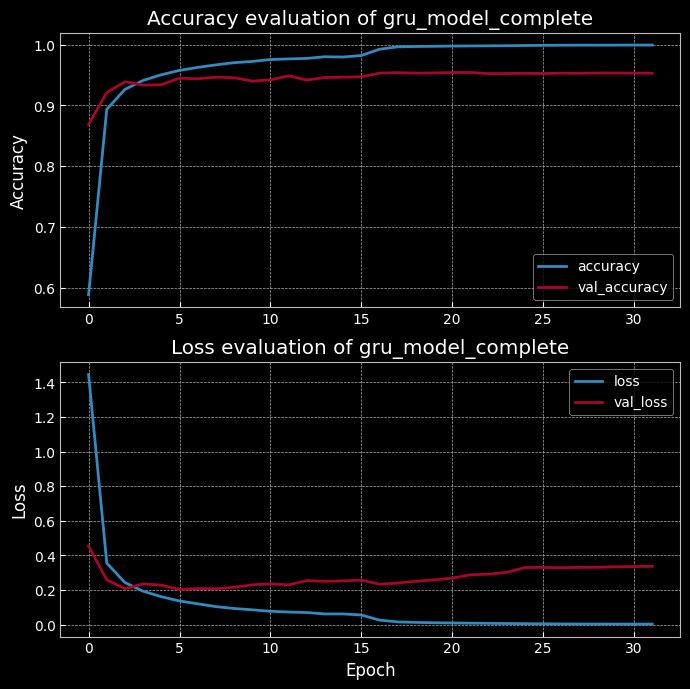

In [ ]:
# plot the performances
ts.plot_history(history, gru_name, filename='accuracy_loss_{}.png'.format(gru_name))

### 5. Analyze predictions and confusion matrix of the model

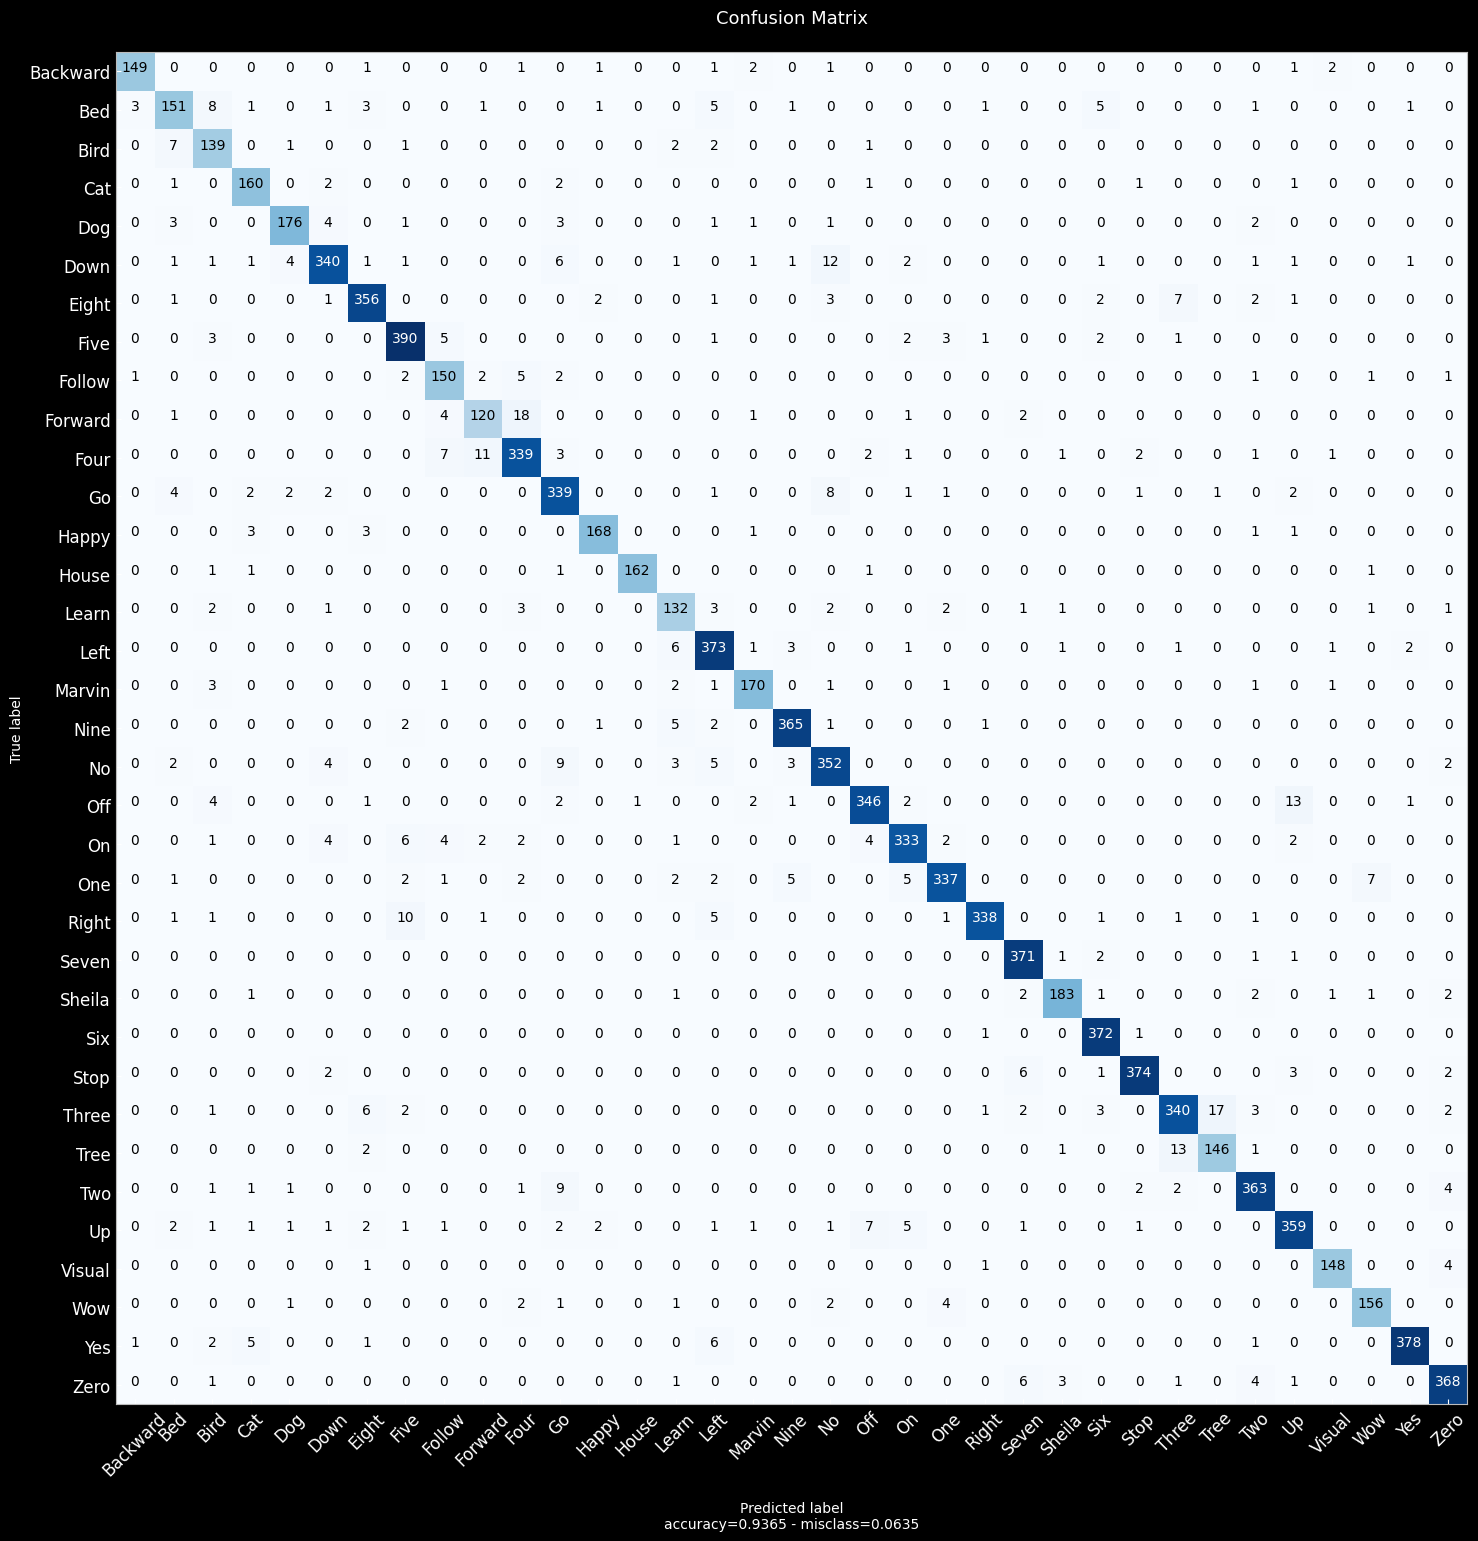

In [ ]:
y_pred = gru_model.predict(X_test_envelope, verbose=0)
matrix  = confusion_matrix(y_test, y_pred.argmax(axis=1))
ts.plot_confusion_matrix(matrix, LABELS_35_CLASSES)

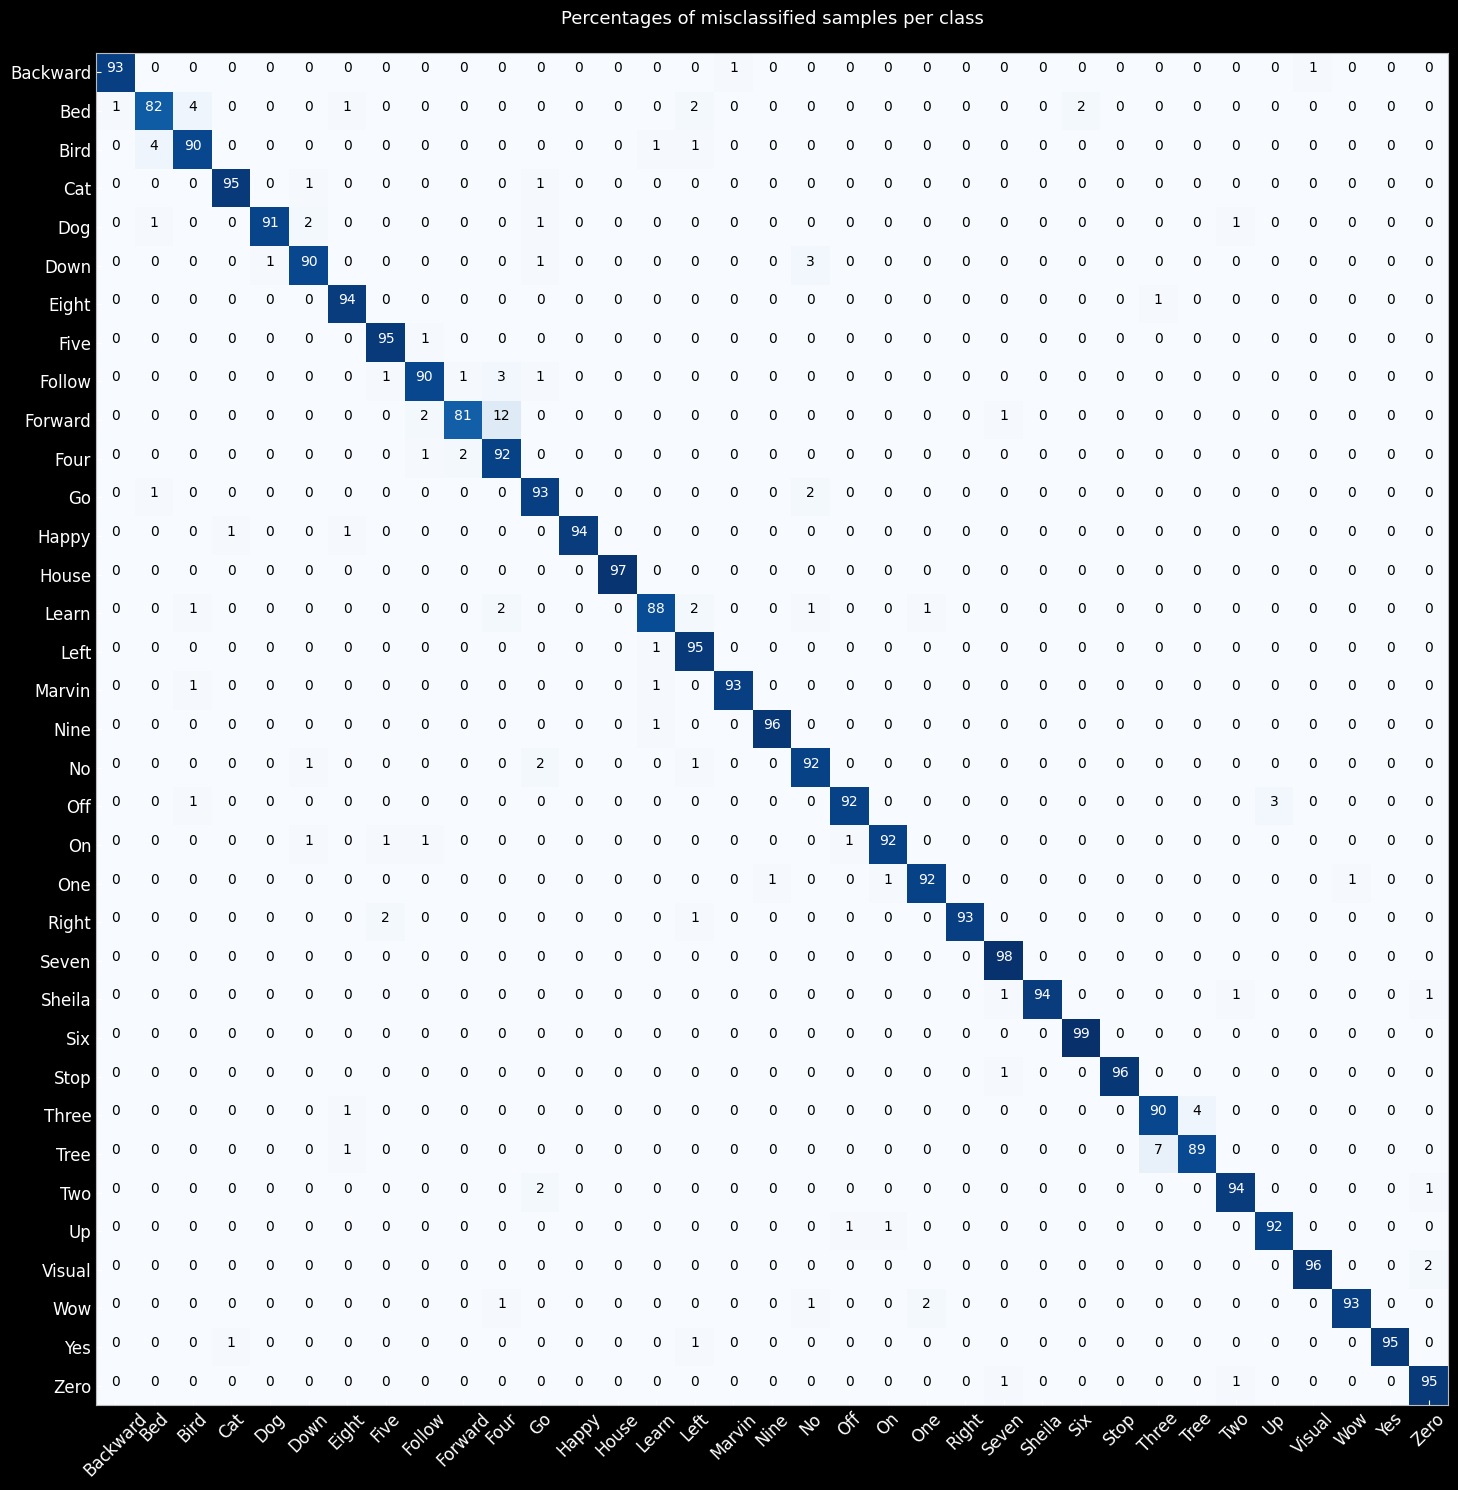

In [ ]:
percentages_misclassified_samples = np.ones_like(matrix)
sums = np.sum(matrix, axis = 1)

for i in range(matrix.shape[0]):
    percentages_misclassified_samples[i] = matrix[i] / sums[i] * 100

# percentages_misclassified_samples
ts.plot_confusion_matrix(percentages_misclassified_samples, LABELS_35_CLASSES, title = "Percentages of misclassified samples per class", display_metrics = False)

Prediction time

In [14]:
ts.prediction_time(gru_model, X_test_envelope)

Average prediction time (ms): 44.41401077194085


### 6. Save the model

In [ ]:
# save model
gru_model.save('{}.h5'.format(gru_name))

## Long short-term memory (LSTM) 

### 1. Build the model

In [ ]:
# Create network
lstm_name = 'lstm_model_complete'
lstm_model = ts.rnn_architecture(name = lstm_name, input_shape = INPUT_SHAPE, rnn = 'LSTM', num_classes = NUM_CATEGORIES_COMPLETE)

Model: "lstm_model_complete"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 13, 99, 1)]       0         
                                                                 
 permute (Permute)           (None, 99, 13, 1)         0         
                                                                 
 batch_norm0 (BatchNormaliza  (None, 99, 13, 1)        4         
 tion)                                                           
                                                                 
 conv0 (Conv2D)              (None, 99, 13, 10)        60        
                                                                 
 batch_norm1 (BatchNormaliza  (None, 99, 13, 10)       40        
 tion)                                                           
                                                                 
 conv1 (Conv2D)              (None, 99, 13, 1) 

### 2. Train the model 

In [ ]:
# train network
history = ts.rnn_training(model = lstm_model, 
                model_name = lstm_name,
                epochs = EPOCHS, 
                batch_size = BATCH_SIZE, 
                patience = PATIENCE, 
                X_train = X_train_envelope, 
                y_train = y_train, 
                X_validation = X_valid_envelope, 
                y_validation = y_valid)

Epoch 1/100
2387/2387 [==============================] - 65s 21ms/step - loss: 1.8977 - sparse_categorical_accuracy: 0.4544 - val_loss: 0.7550 - val_sparse_categorical_accuracy: 0.7786 - lr: 0.0010
Epoch 2/100
2387/2387 [==============================] - 48s 20ms/step - loss: 0.5470 - sparse_categorical_accuracy: 0.8391 - val_loss: 0.3866 - val_sparse_categorical_accuracy: 0.8816 - lr: 0.0010
Epoch 3/100
2387/2387 [==============================] - 47s 20ms/step - loss: 0.3247 - sparse_categorical_accuracy: 0.9045 - val_loss: 0.2780 - val_sparse_categorical_accuracy: 0.9228 - lr: 0.0010
Epoch 4/100
2387/2387 [==============================] - 46s 19ms/step - loss: 0.2491 - sparse_categorical_accuracy: 0.9245 - val_loss: 0.2431 - val_sparse_categorical_accuracy: 0.9306 - lr: 0.0010
Epoch 5/100
2387/2387 [==============================] - 46s 19ms/step - loss: 0.1968 - sparse_categorical_accuracy: 0.9396 - val_loss: 0.2647 - val_sparse_categorical_accuracy: 0.9244 - lr: 0.0010
Epoch 6/10

### 3. Evaluate the model 

In [ ]:
# evaluate network on test set
test_loss, test_acc = lstm_model.evaluate(X_test_envelope, y_test)
print("\nTest loss: {}, test accuracy: {}".format(test_loss, 100*test_acc)) 

316/316 [==============================] - 3s 9ms/step - loss: 0.3132 - sparse_categorical_accuracy: 0.9369

Test loss: 0.31318432092666626, test accuracy: 93.69235634803772


### 4. Plot performance of the model

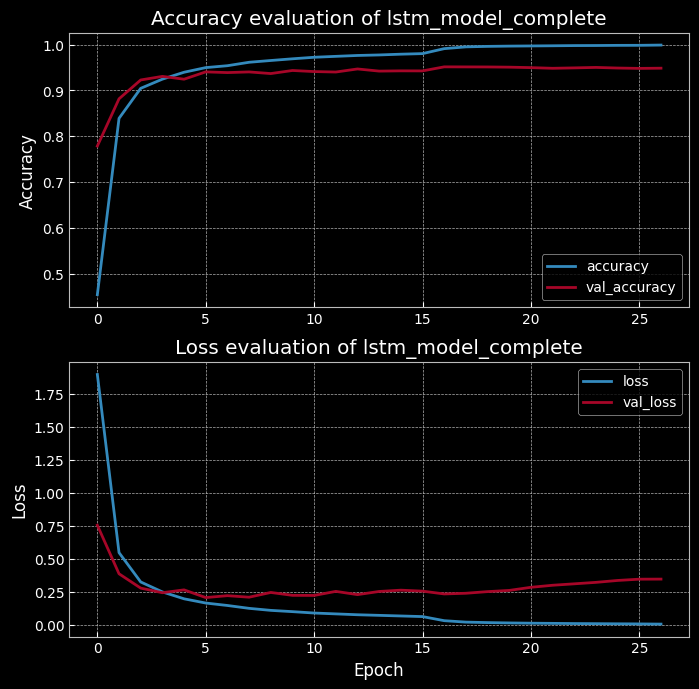

In [ ]:
# plot the performances
ts.plot_history(history, lstm_name, filename='accuracy_loss_{}.png'.format(lstm_name))

### 5. Analyze predictions and confusion matrix of the model

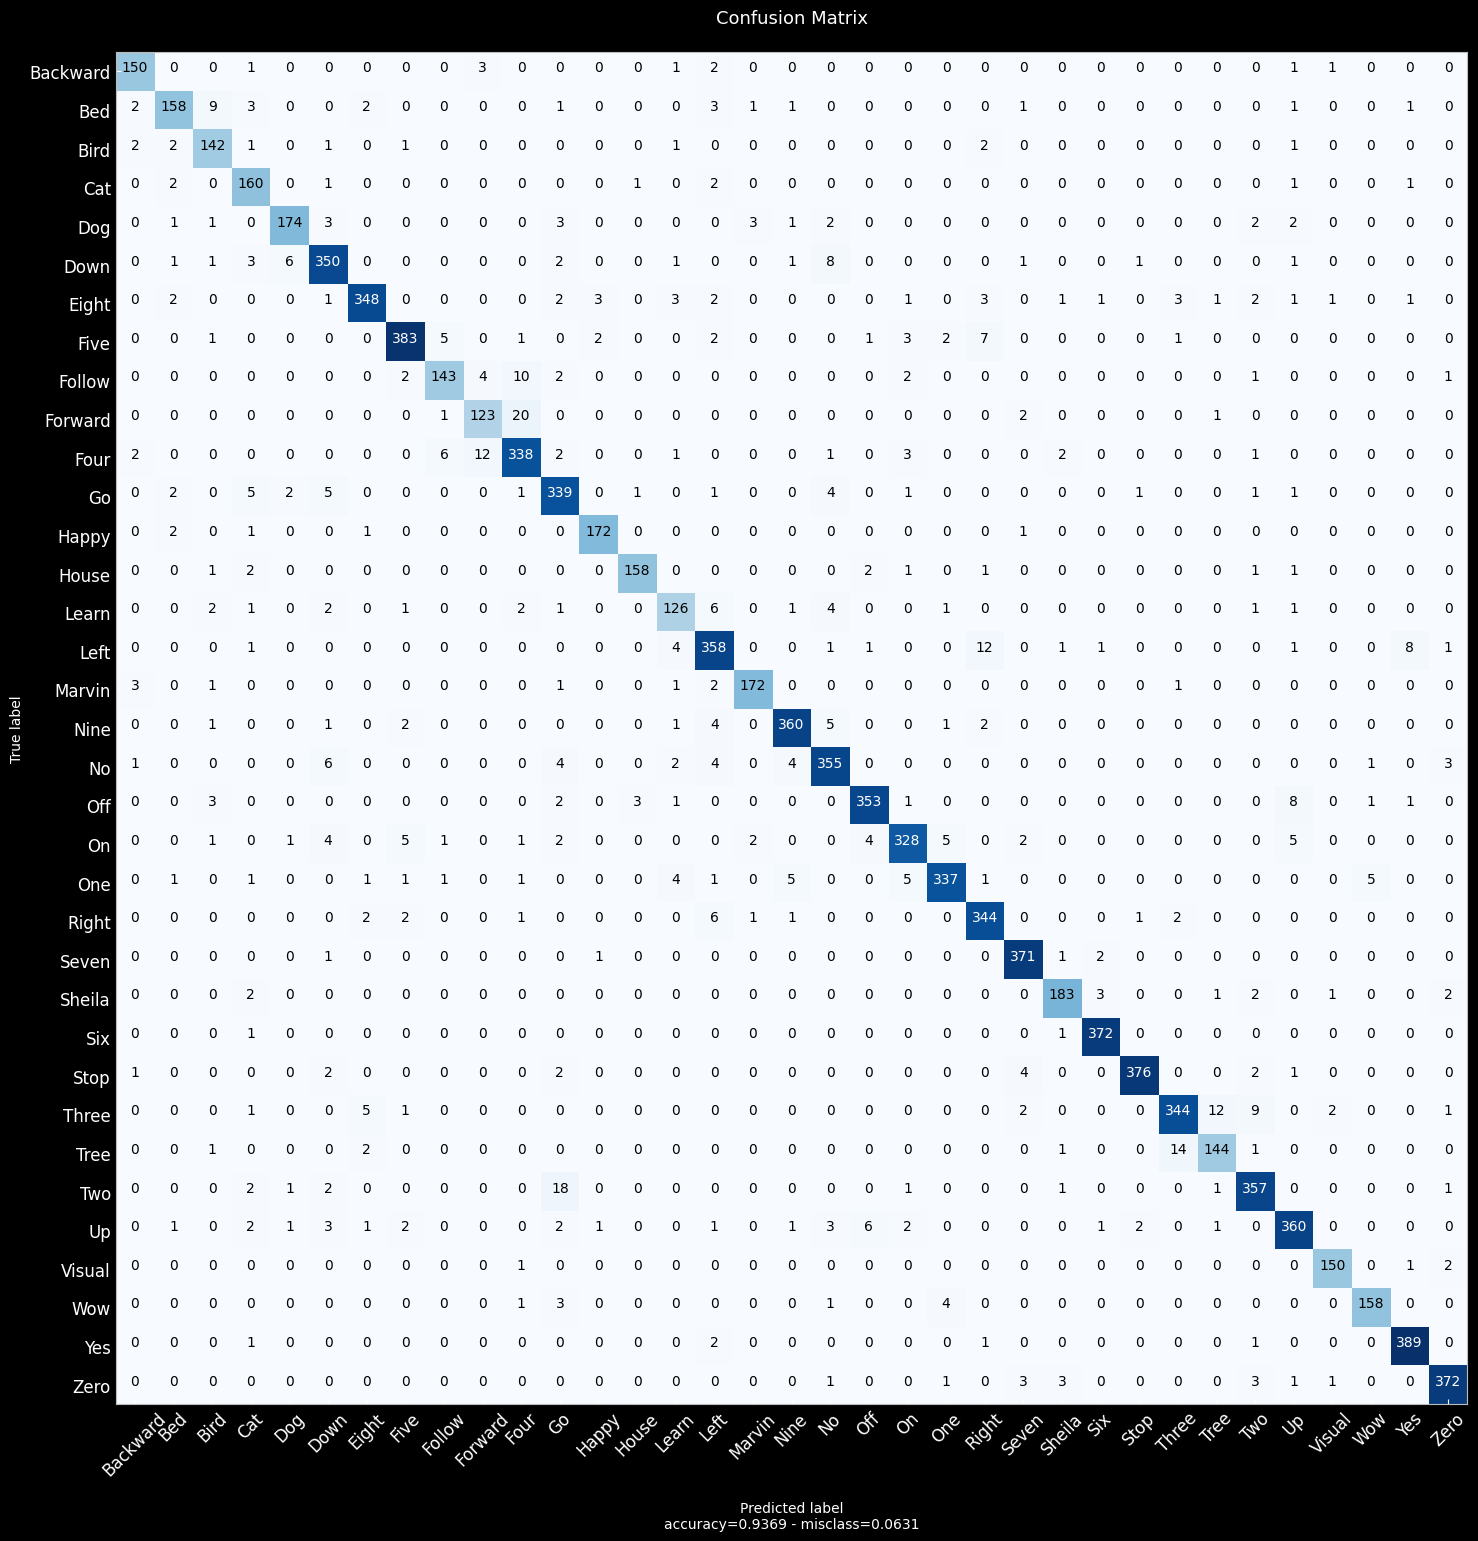

In [ ]:
y_pred = lstm_model.predict(X_test_envelope, verbose=0)
matrix  = confusion_matrix(y_test, y_pred.argmax(axis=1))
ts.plot_confusion_matrix(matrix, LABELS_35_CLASSES)

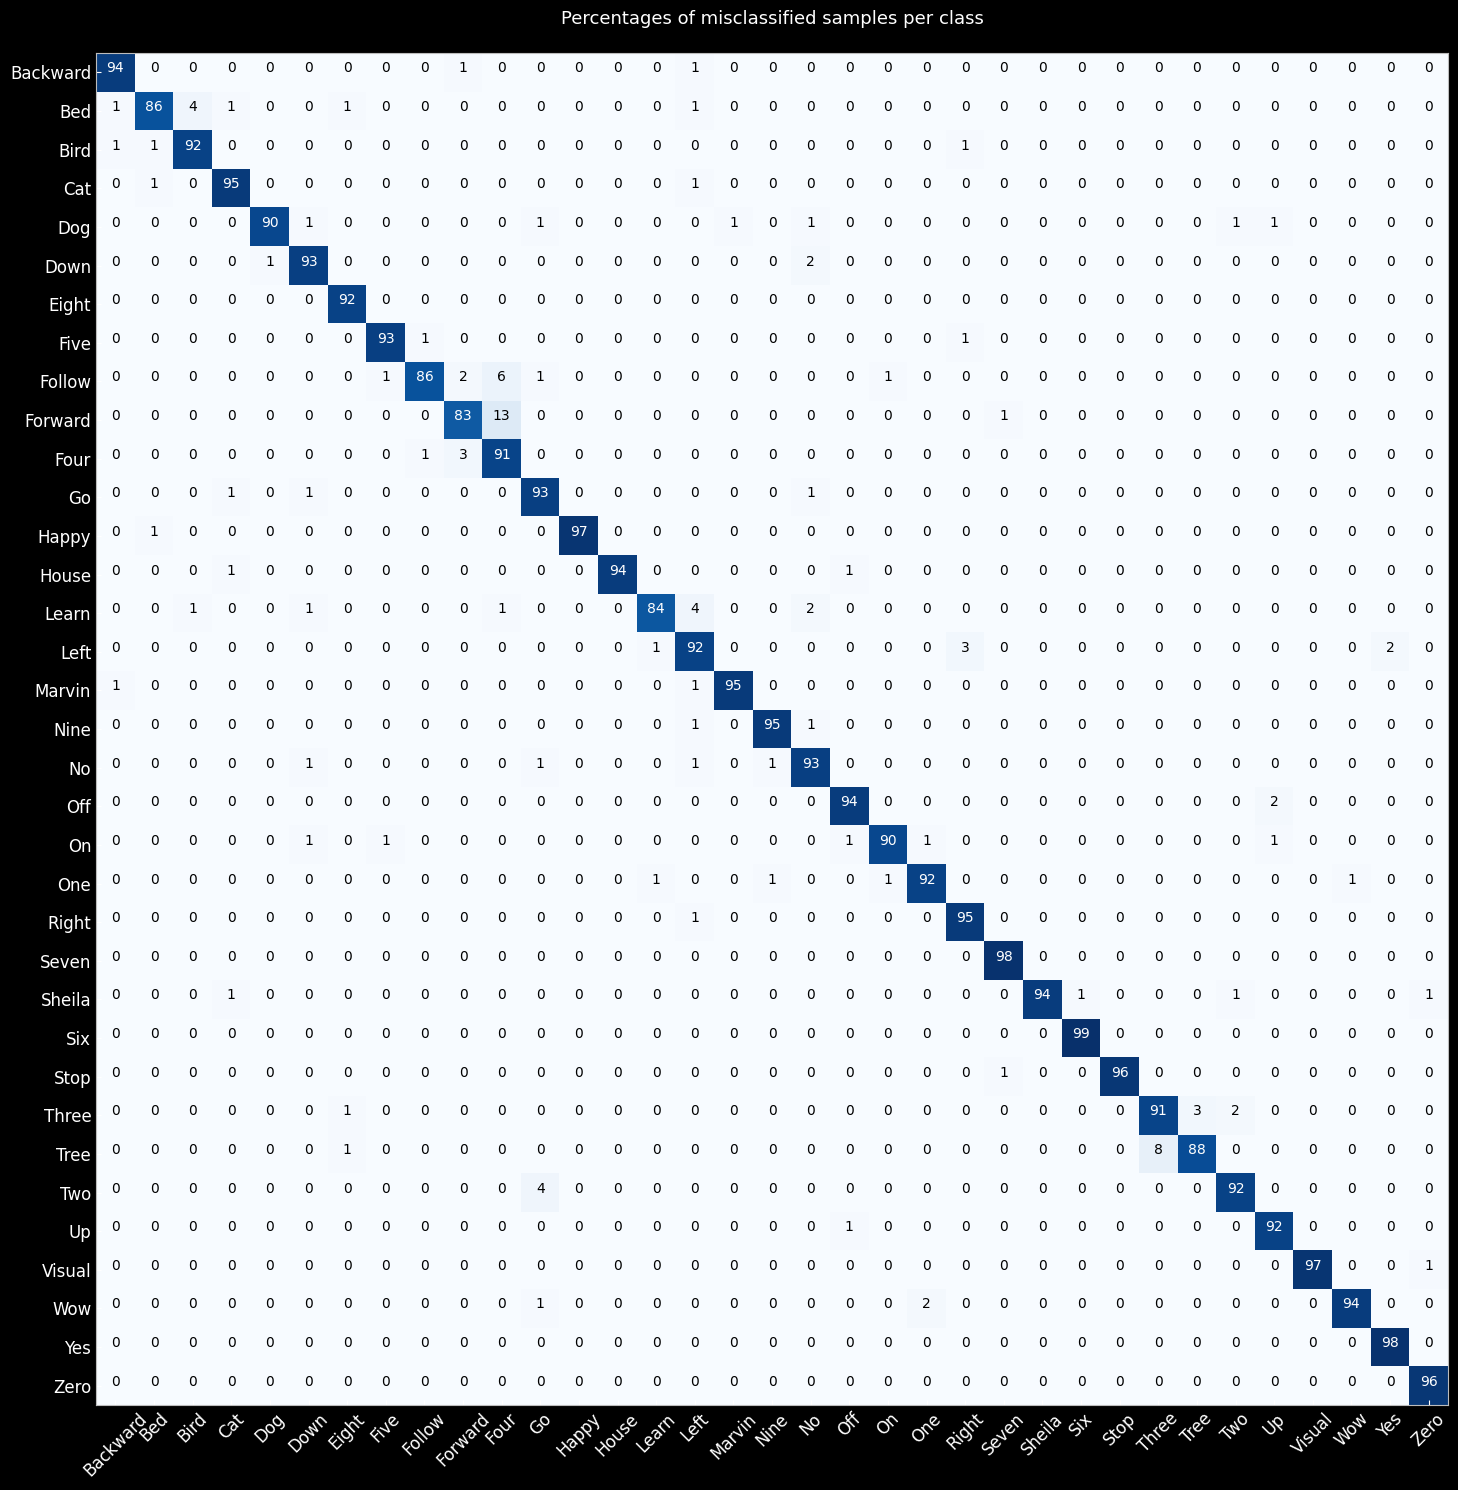

In [ ]:
percentages_misclassified_samples = np.ones_like(matrix)
sums = np.sum(matrix, axis = 1)

for i in range(matrix.shape[0]):
    percentages_misclassified_samples[i] = matrix[i] / sums[i] * 100

# percentages_misclassified_samples
ts.plot_confusion_matrix(percentages_misclassified_samples, LABELS_35_CLASSES, title = "Percentages of misclassified samples per class", display_metrics = False)

Prediction time

In [ ]:
ts.prediction_time(lstm_model, X_test_envelope)

Average prediction time (ms): 51.51542109722124


#### Examples of incorrectly classified test samples

##### Most common errors 

In [ ]:
filenames_incorrect, y_true, y_pred, errors_per_category = ts.wrong_predictions(lstm_model, X_test_envelope, y_test, filenames_test)
print(errors_per_category.most_common(4))

[('on', 33), ('three', 33), ('left', 31), ('four', 30)]


In [ ]:
# categories that are most often confused
errors_on_one = []
errors_three_tree = []
errors_left_learn = []
errors_four_forward = []

for i in range(len(filenames_incorrect)):
  if y_true[i] == LABELS_35_CLASSES.get('on') and y_pred[i] == LABELS_35_CLASSES.get('one'): # error between 'on' and 'one' categories
    errors_on_one.append(i)
  if y_true[i] == LABELS_35_CLASSES.get('three') and y_pred[i] == LABELS_35_CLASSES.get('tree'): # error between 'three' and 'tree' categories
    errors_three_tree.append(i)
  if y_true[i] == LABELS_35_CLASSES.get('left') and y_pred[i] == LABELS_35_CLASSES.get('learn'): # error between 'left' and 'learn' categories
    errors_left_learn.append(i)
  if y_true[i] == LABELS_35_CLASSES.get('four') and y_pred[i] == LABELS_35_CLASSES.get('forward'): # error between 'four' and 'forward' categories
    errors_four_forward.append(i)

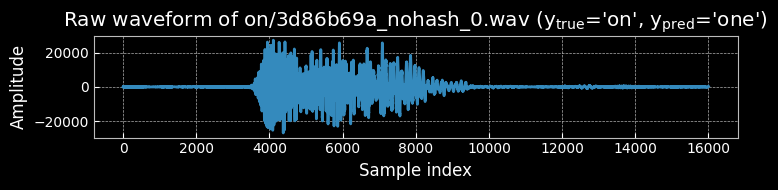

In [ ]:
ds.plot_audio(DATASET_PATH, filenames_incorrect[errors_on_one[0]], '\'on\'', '\'one\'')

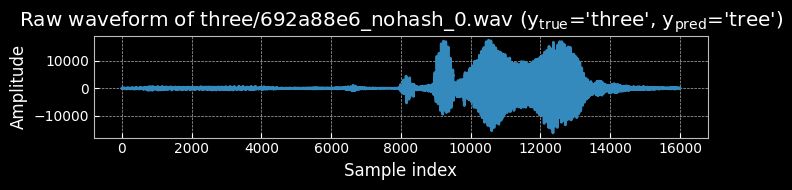

In [ ]:
ds.plot_audio(DATASET_PATH, filenames_incorrect[errors_three_tree[0]], '\'three\'', '\'tree\'')

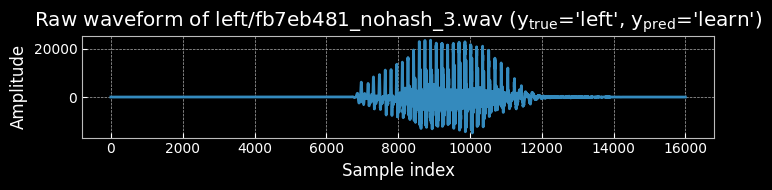

In [ ]:
ds.plot_audio(DATASET_PATH, filenames_incorrect[errors_left_learn[3]], '\'left\'', '\'learn\'')

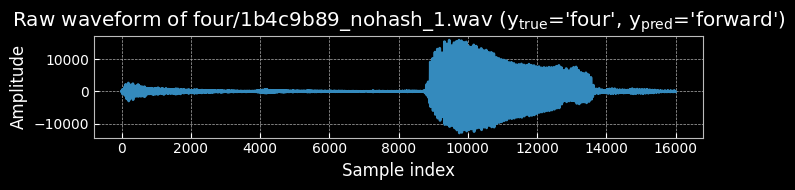

In [ ]:
ds.plot_audio(DATASET_PATH, filenames_incorrect[errors_four_forward[0]], '\'four\'', '\'forward\'')

##### Strange errors

In [ ]:
# categories very different that however are confused
errors_backward_cat = []
errors_sheila_two = []
errors_dog_marvin = []
errors_yes_right = []
errors_on_five = []
errors_dog_bird = []
errors_go_stop = []
errors_bed_nine = []

for i in range(len(filenames_incorrect)):
  if y_true[i] == LABELS_35_CLASSES.get('backward') and y_pred[i] == LABELS_35_CLASSES.get('cat'): # error between 'backward' and 'cat' categories
    errors_backward_cat.append(i)
  if y_true[i] == LABELS_35_CLASSES.get('sheila') and y_pred[i] == LABELS_35_CLASSES.get('two'): # error between 'sheila' and 'two' categories
    errors_sheila_two.append(i)
  if y_true[i] == LABELS_35_CLASSES.get('dog') and y_pred[i]==LABELS_35_CLASSES.get('marvin'): # error between 'dog' and 'marvin' categories
    errors_dog_marvin.append(i)
  if y_true[i] == LABELS_35_CLASSES.get('yes') and y_pred[i] == LABELS_35_CLASSES.get('right'): # error between 'yes' and 'right' categories
    errors_yes_right.append(i) 
  if y_true[i] == LABELS_35_CLASSES.get('on') and y_pred[i] == LABELS_35_CLASSES.get('five'): # error between 'on' and 'five' categories
    errors_on_five.append(i) 
  if y_true[i] == LABELS_35_CLASSES.get('dog') and y_pred[i] == LABELS_35_CLASSES.get('bird'): # error between 'dog' and 'bird' categories
    errors_dog_bird.append(i) 
  if y_true[i] == LABELS_35_CLASSES.get('go') and y_pred[i] == LABELS_35_CLASSES.get('stop'): # error between 'go' and 'stop' categories
    errors_go_stop.append(i) 
  if y_true[i] == LABELS_35_CLASSES.get('bed') and y_pred[i] == LABELS_35_CLASSES.get('nine'): # error between 'bed' and 'nine' categories
    errors_bed_nine.append(i)

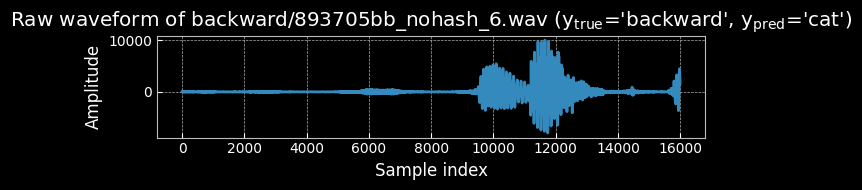

In [ ]:
ds.plot_audio(DATASET_PATH, filenames_incorrect[errors_backward_cat[0]], '\'backward\'', '\'cat\'') # the word is not entirelly pronounced

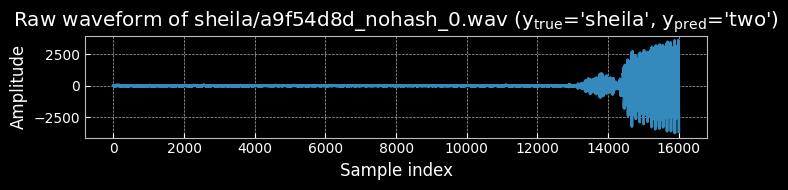

In [ ]:
ds.plot_audio(DATASET_PATH, filenames_incorrect[errors_sheila_two[0]], '\'sheila\'', '\'two\'') # the word is not perfectly centered inside the 1s 

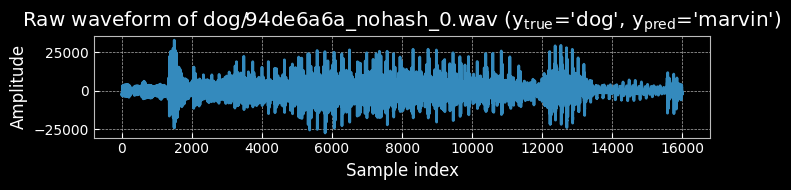

In [ ]:
ds.plot_audio(DATASET_PATH, filenames_incorrect[errors_dog_marvin[2]], '\'dog\'', '\'marvin\'') # very strange noise

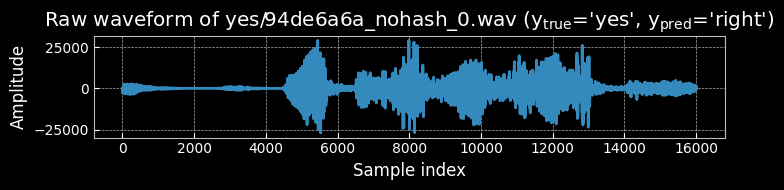

In [ ]:
ds.plot_audio(DATASET_PATH, filenames_incorrect[errors_yes_right[0]], '\'yes\'', '\'right\'') # another person is laughing in the background

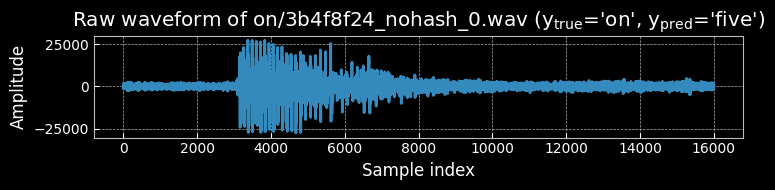

In [ ]:
ds.plot_audio(DATASET_PATH, filenames_incorrect[errors_on_five[0]], '\'on\'', '\'five\'') # bad quality recordings

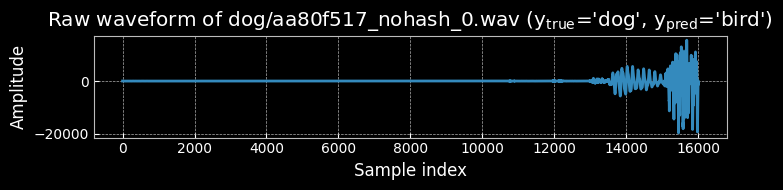

In [ ]:
ds.plot_audio(DATASET_PATH, filenames_incorrect[errors_dog_bird[0]], '\'dog\'', '\'bird\'') # the word is not perfectly centered inside the 1s 

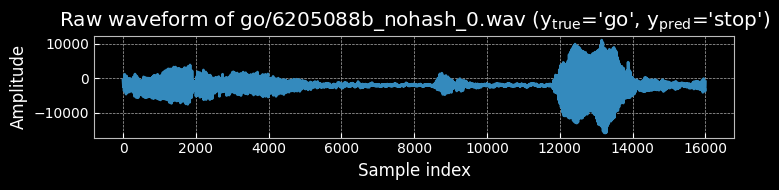

In [ ]:
ds.plot_audio(DATASET_PATH, filenames_incorrect[errors_go_stop[0]], '\'go\'', '\'stop\'') # bad quality recordings + # another person is laughing in the background

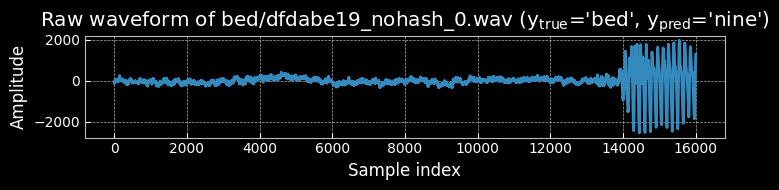

In [ ]:
ds.plot_audio(DATASET_PATH, filenames_incorrect[errors_bed_nine[0]], '\'bed\'', '\'nine\'') # the word is not perfectly centered inside the 1s 

### 6. Save the model

In [ ]:
# save model
lstm_model.save('{}.h5'.format(lstm_name))